In [1]:
%load_ext autoreload
#%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import warnings
import logging
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

logging.basicConfig(level=logging.INFO)

time: 822 ms (started: 2024-05-29 13:22:12 -07:00)


In [143]:
df = pd.read_csv("raw_pivoted.csv2.gz", compression="gzip", index_col=0)
df

,failed,success
timestamp,,
2024-03-09 23:28,NaN,1.0
2024-03-09 23:34,NaN,1.0
2024-03-09 23:36,NaN,1.0
2024-03-09 23:45,NaN,1.0
2024-03-09 23:47,NaN,1.0
...,...,...
2024-03-22 23:58,1.0,176.0
2024-03-22 23:59,NaN,7.0
2024-03-23 00:00,NaN,3.0


time: 12.2 ms (started: 2024-05-29 16:23:14 -07:00)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

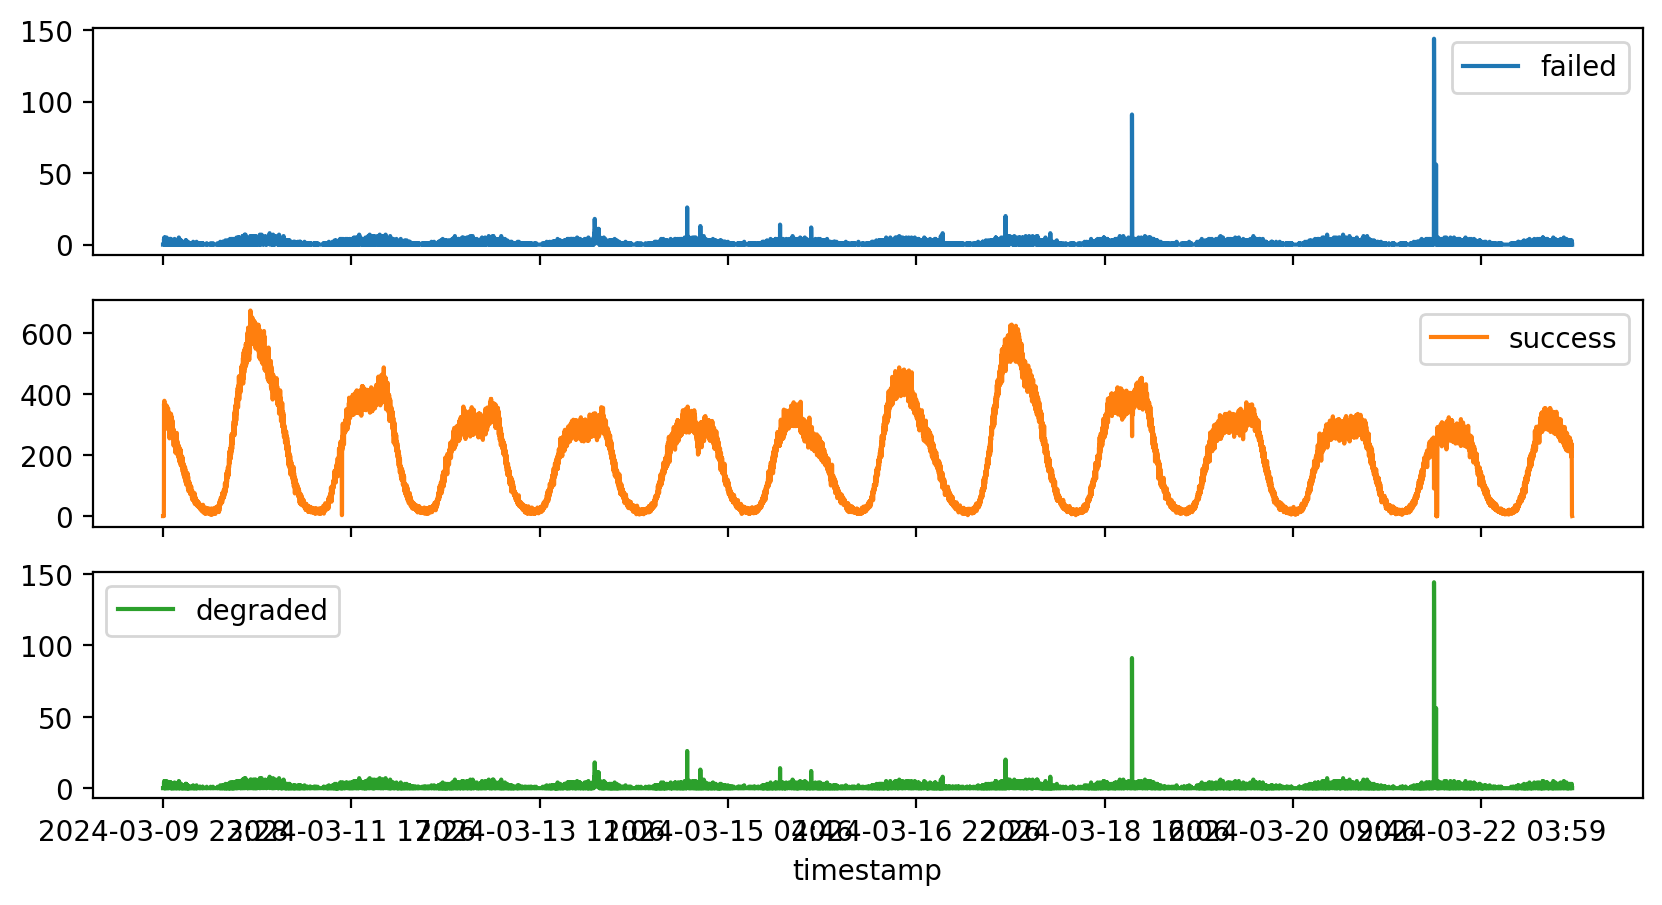

time: 301 ms (started: 2024-05-29 16:23:14 -07:00)


In [144]:
df = df.fillna(0)
df["degraded"] = df[["failed"]]
df.plot(subplots=True)

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

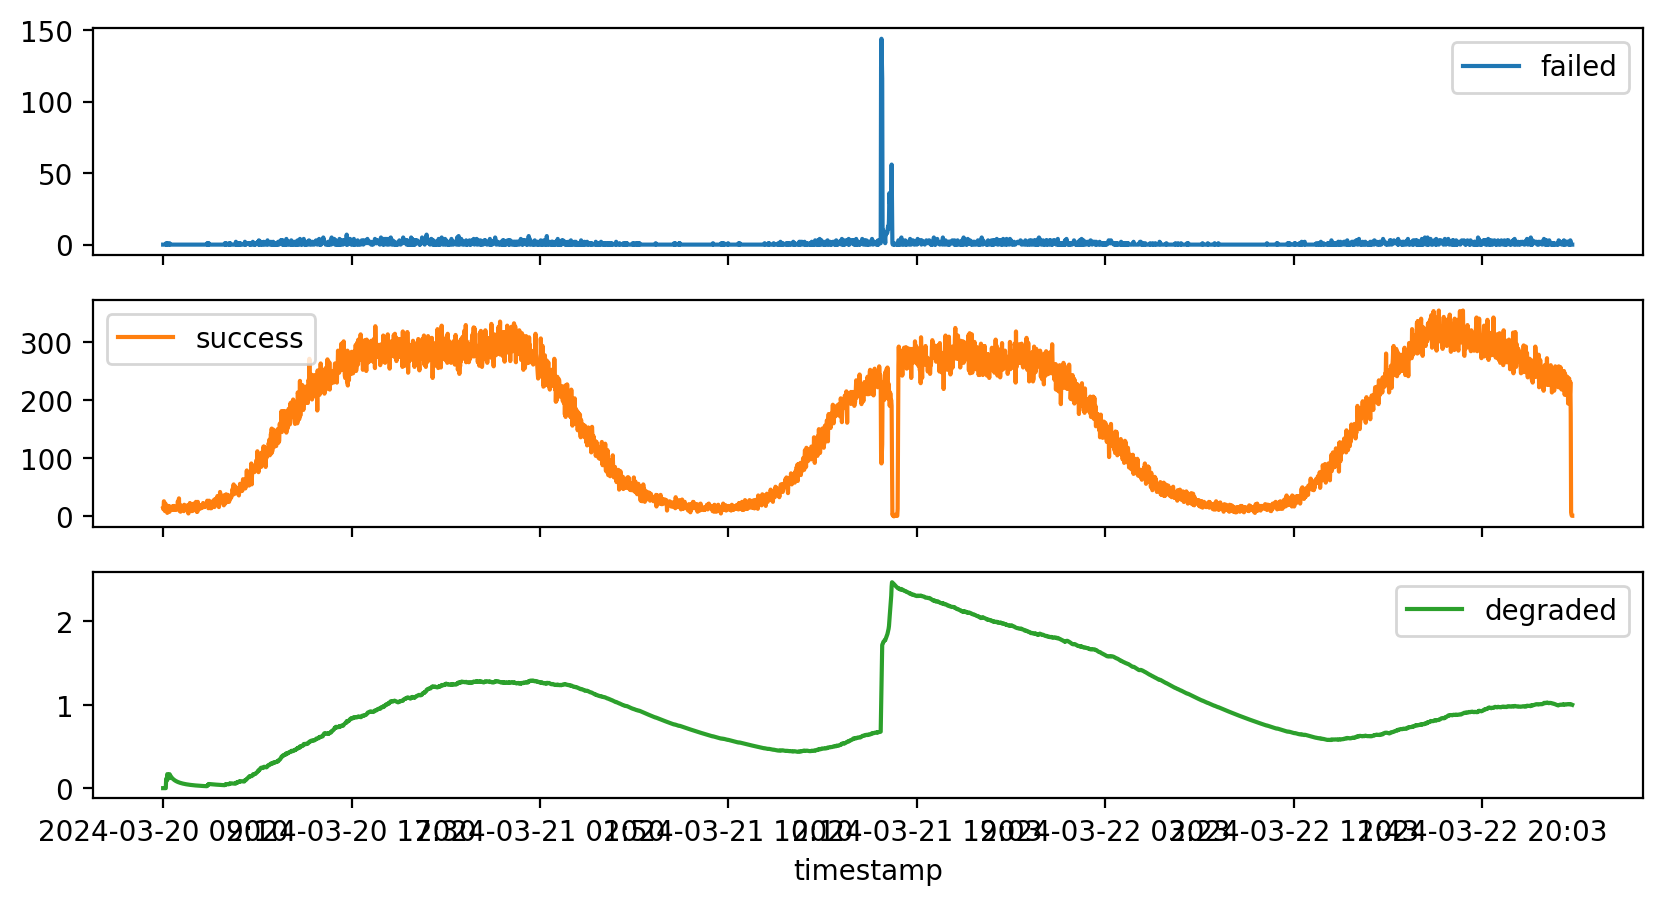

time: 245 ms (started: 2024-05-29 16:23:15 -07:00)


In [145]:
TEST_SPLIT_RATIO = 0.2
df_train, df_test = df.iloc[:-int(TEST_SPLIT_RATIO * (len(df)))], df.iloc[-int(TEST_SPLIT_RATIO * (len(df))):]
df_test["degraded"] = df_test["degraded"].ewm(span=1000).mean()
df_test.plot(subplots=True)

In [146]:
from numalogic.transforms import LogTransformer

tx = LogTransformer()
x_train = tx.fit_transform(df_train.to_numpy())
x_test = tx.transform(df_test.to_numpy())

time: 1.23 ms (started: 2024-05-29 16:23:20 -07:00)


In [147]:
from torch.utils.data import DataLoader
from numalogic.tools.data import StreamingDataset
from numalogic.models.autoencoder import TimeseriesTrainer
from numalogic.models.autoencoder.variants import VanillaAE

train_ds = StreamingDataset(x_train, seq_len=10)
test_ds = StreamingDataset(x_test, seq_len=10)

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1


time: 2.08 ms (started: 2024-05-29 16:23:21 -07:00)


In [148]:

trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
model_1 = VanillaAE(n_features=3, seq_len=10, encoder_layersizes=[24, 12], decoder_layersizes=[12, 24])
trainer.fit(model_1, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.7001
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.8528
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3388
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.2562
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2222
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2065
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.1931
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.1833
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.1783
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1749
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1667
INFO:pytorch_lightning.utilit

time: 5.02 s (started: 2024-05-29 16:23:21 -07:00)


In [149]:
import torch

test_reconerr = trainer.predict(model_1, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
test_reconerr.shape

(3731, 3)

time: 16.5 ms (started: 2024-05-29 16:23:28 -07:00)


[0.03614454 0.04221676 0.00137655] [0.05909718 0.08244062 0.00098102]


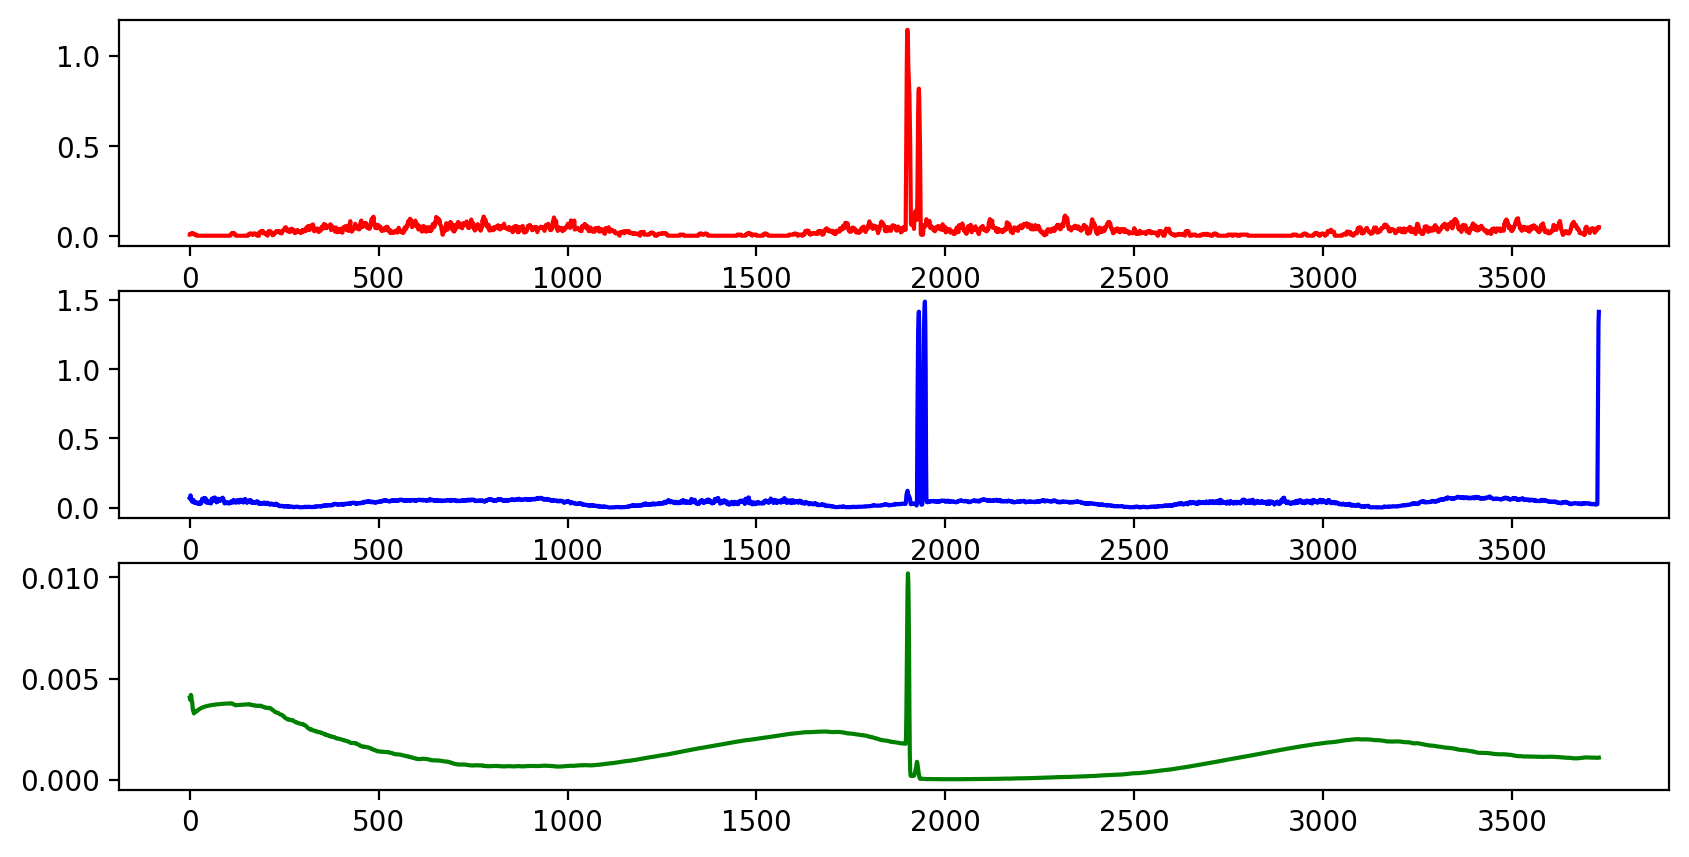

time: 188 ms (started: 2024-05-29 16:23:29 -07:00)


In [150]:
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

In [154]:
error_train_ds = StreamingDataset(x_train[:, [2]], seq_len=10)
error_test_ds = StreamingDataset(x_test[:, [2]], seq_len=10)

trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
model_2 = VanillaAE(seq_len=10)
trainer.fit(model_2, train_dataloaders=DataLoader(error_train_ds, batch_size=512))

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.5955
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.1778
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.1132
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0806
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0651
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0581
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0523
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0490
INFO:numalogic.tools.callbacks:epoch=40,

time: 3.5 s (started: 2024-05-29 16:24:01 -07:00)


0.00047173048 0.0009520947


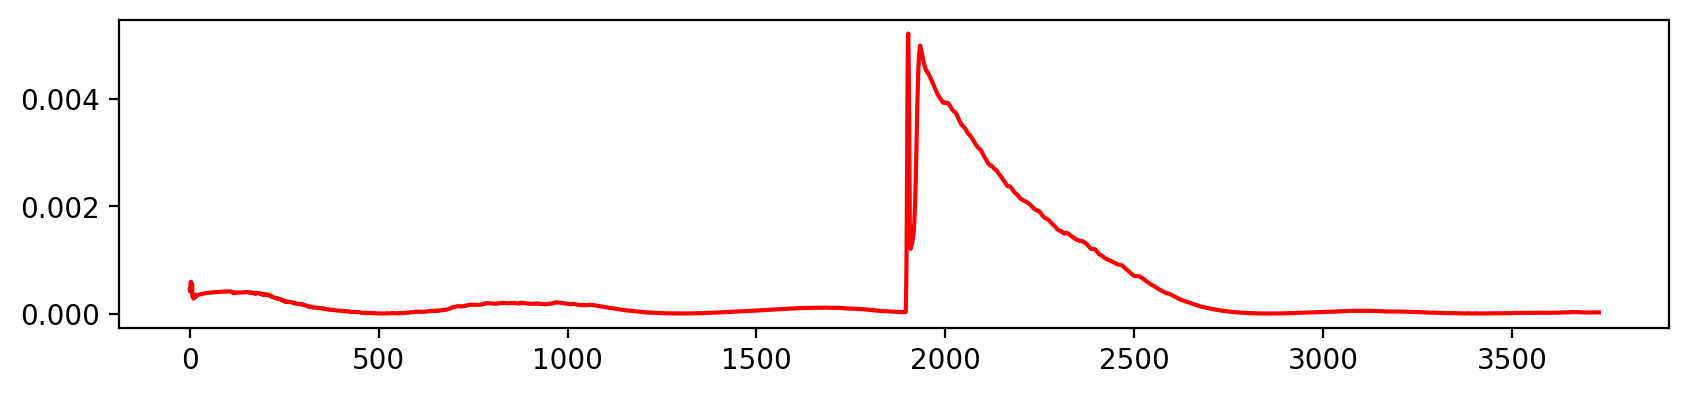

time: 86.8 ms (started: 2024-05-29 16:24:05 -07:00)


In [155]:
test_reconerr = trainer.predict(model_2, dataloaders=DataLoader(error_test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
_, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.plot(test_reconerr, color="red")
print(np.mean(test_reconerr), np.std(test_reconerr))
# ax[1].plot(test_reconerr[:, 1], color="blue")
# ax[2].plot(test_reconerr[:, 2], color="green")

In [156]:
from numalogic.models.autoencoder.variants.vanilla import MultichannelAE

model_3 = MultichannelAE(seq_len=10, n_channels=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.6272
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.5651
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3165
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.2558
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2122
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.1843
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.1726
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.1590
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.1497
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1425
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1342
INFO:pytorch_lightning.utilit

time: 5.6 s (started: 2024-05-29 16:24:12 -07:00)


[0.02863926 0.03242528 0.00056137] [0.07924399 0.09658159 0.00115547]


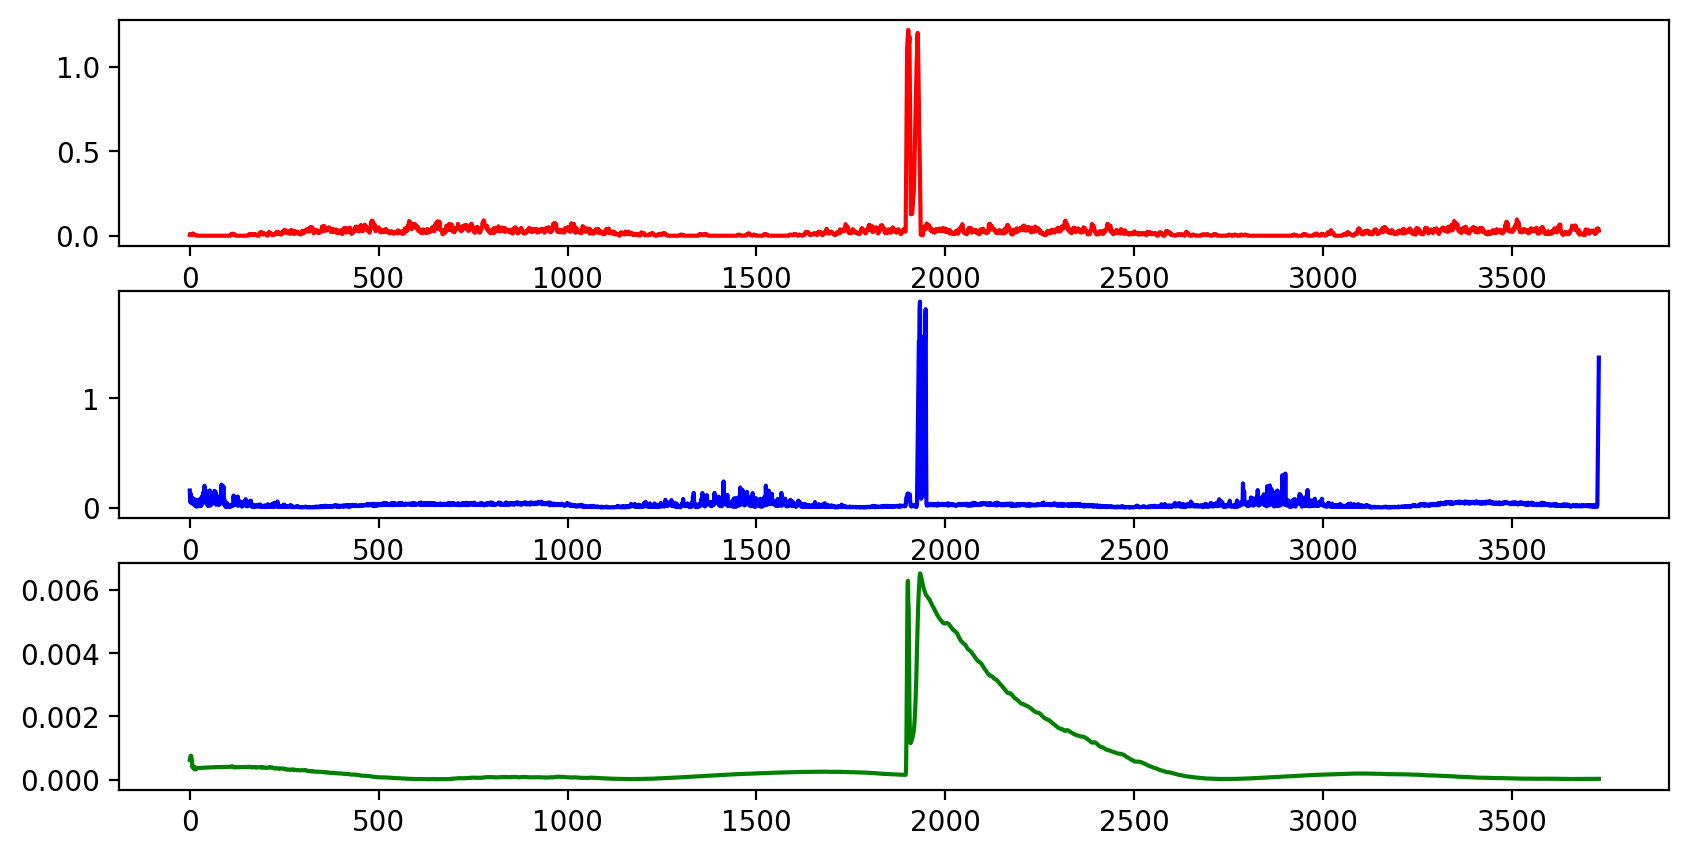

time: 236 ms (started: 2024-05-29 16:24:18 -07:00)


In [157]:
test_reconerr = trainer.predict(model_3, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.6532
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.7445
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3185
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.2661
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2000
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.1790
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.1667
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.1547
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.1479
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1379
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1328
INFO:pytorch_lightning.utilit

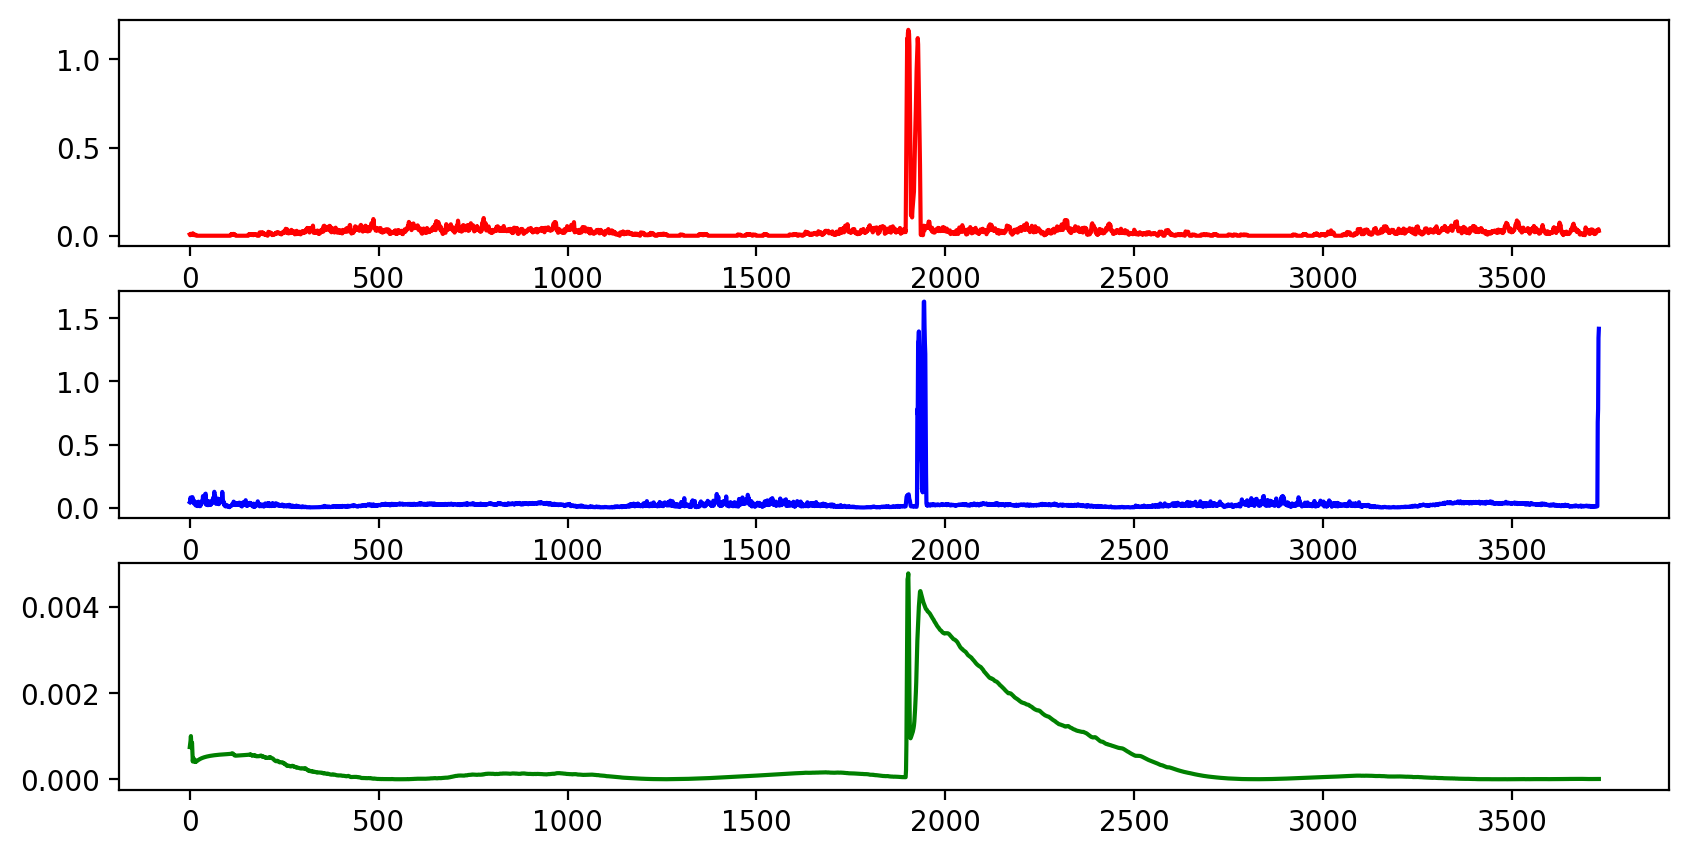

time: 6.13 s (started: 2024-05-29 16:24:22 -07:00)


In [158]:
model_3 = MultichannelAE(seq_len=10, n_channels=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3, train_dataloaders=DataLoader(train_ds, batch_size=512))

test_reconerr = trainer.predict(model_3, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")

In [142]:
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

[0.03049051 0.02789014 0.00610527] [0.0817422  0.08140289 0.0379023 ]
time: 1.15 ms (started: 2024-05-29 16:22:30 -07:00)
